# Bicycle-stations Availability Prediction

Use a supervised machine learning algorithm to predict the availability for each bicyle-sharing stations in Lyon (France) based on the history data.

I use the tree method [XGBoost](http://xgboost.readthedocs.io/en/latest/model.html) to predict a "probability" of bikes availability for each station. A number close to 1. means that you have several available bikes. A number close to 0. means you don't have many bikes.

## Some Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, train_test_split

In [3]:
import xgboost as xgb
from xgboost import plot_tree

/Users/babou/anaconda/envs/python3DS/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
import folium

In [6]:
%load_ext watermark

In [7]:
%watermark -d -v -p numpy,pandas,xgboost,matplotlib,folium -g -m -w

2017-11-16 

CPython 3.5.3
IPython 6.1.0

numpy 1.13.1
pandas 0.20.3
xgboost 0.6
matplotlib 2.0.2
folium 0.5.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 17.2.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : e0ac261935cd81c45afabcdd47f46fbdb1973486
watermark 1.5.0


The module `prediction.py` contains some functions dedicated to the bicyle-sharing stations predictions.

In [8]:
from prediction import (datareader, complete_data, cleanup, bikes_probability,
                        time_resampling, prepare_data_for_training, fit, prediction,
                       get_weather)
np.random.seed(42)

## Read and prepare the data

In [9]:
DATAFILE = './data/lyon.csv'

In [10]:
raw = datareader(DATAFILE)

2017-11-16 11:09:58,461 [7174] INFO     prediction: read the file './data/lyon.csv'


In [11]:
raw[raw['number'] == 1005].tail()

,number,last_update,bike_stands,available_bike_stands,available_bikes,availabilitycode,availability,bonus,status
7522659,1005,2017-09-26 14:31:50,10,10,0,3,Orange,Non,OPEN
7523006,1005,2017-09-26 14:41:54,10,10,0,3,Orange,Non,OPEN
7523353,1005,2017-09-26 14:41:54,10,10,0,3,Orange,Non,OPEN
7523700,1005,2017-09-26 14:51:57,10,10,0,3,Orange,Non,OPEN
7524047,1005,2017-09-26 14:55:17,10,10,0,3,Orange,Non,OPEN


Min and max dates of the timeseries

In [12]:
print(raw.last_update.min())
print(raw.last_update.max())

2017-07-08 00:30:12
2017-09-26 14:58:46


In [13]:
raw[(raw.number == 1001) &(raw.last_update >= "2017-07-26 09:00:00")].head(10)

,number,last_update,bike_stands,available_bike_stands,available_bikes,availabilitycode,availability,bonus,status
1613382,1001,2017-07-26 09:04:23,16,13,3,1,Vert,Non,OPEN
1613730,1001,2017-07-26 09:05:33,16,14,2,1,Vert,Non,OPEN
1614078,1001,2017-07-26 09:05:33,16,14,2,1,Vert,Non,OPEN
1614426,1001,2017-07-26 09:18:02,16,16,0,3,Orange,Non,OPEN
1614774,1001,2017-07-26 09:18:02,16,16,0,3,Orange,Non,OPEN
1615122,1001,2017-07-26 09:28:07,16,16,0,3,Orange,Non,OPEN
1615470,1001,2017-07-26 09:29:43,16,15,1,1,Vert,Non,OPEN
1615818,1001,2017-07-26 09:36:35,16,14,2,1,Vert,Non,OPEN
1616166,1001,2017-07-26 09:39:16,16,14,2,1,Vert,Non,OPEN
1616514,1001,2017-07-26 09:49:21,16,15,1,1,Vert,Non,OPEN


In [14]:
df_clean = cleanup(raw)

2017-11-16 11:10:16,554 [7174] INFO     prediction: cleanup processing


Pipe some processing data functions :

* time resampling to get data every 10 minutes (i.e. `10T`)
* add some columns : day of the week, hour of the day, etc.
* compute the bikes (number) "probability". It's just a normalization for each station with `num_avail_bikes / total`

In [15]:
df_clean.head()

,station,ts,stands,bikes,bonus,status
0,10063,2017-07-08 23:49:09,10,23,Non,OPEN
2,8038,2017-07-08 23:49:26,6,14,Non,OPEN
3,7045,2017-07-08 23:52:43,13,7,Non,OPEN
4,6045,2017-07-08 23:52:14,7,8,Non,OPEN
5,7062,2017-07-08 23:57:27,5,11,Non,OPEN


In [16]:
df = (df_clean.pipe(time_resampling)
      .pipe(complete_data)
      .pipe(bikes_probability))

2017-11-16 11:10:22,239 [7174] INFO     prediction: Time resampling for each station by '10T'
2017-11-16 11:10:27,332 [7174] INFO     prediction: complete some data
2017-11-16 11:11:12,745 [7174] INFO     prediction: bikes probability


In [17]:
import gc
del df_clean
del raw
gc.collect()

65

In [18]:
df.head()

,station,ts,bikes,stands,is_open,day,hour,minute,probability
0,1001,2017-07-09 00:00:00,15.0,1.0,1.0,6,0,0,0.93750
1,1001,2017-07-09 00:10:00,15.0,1.0,1.0,6,0,10,0.93750
2,1001,2017-07-09 00:20:00,14.5,1.5,1.0,6,0,20,0.90625
3,1001,2017-07-09 00:30:00,14.5,1.5,1.0,6,0,30,0.90625
4,1001,2017-07-09 00:40:00,11.5,4.5,1.0,6,0,40,0.71875


In [19]:
df.shape

(3880901, 9)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880901 entries, 0 to 3880900
Data columns (total 9 columns):
station        int64
ts             datetime64[ns]
bikes          float64
stands         float64
is_open        float64
day            int64
hour           int64
minute         int64
probability    float64
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 266.5 MB


In [23]:
label.head()

0    0.93750
1    0.93750
2    0.90625
3    0.90625
4    0.71875
Name: future, dtype: float64

In [27]:
freq = '1H'
data = df.sort_values(['station', 'ts']).set_index(["ts", "station"])
observation = 'probability'
label = data[observation].copy()
label.name = "future"
label = (label.reset_index(level=1)
         .shift(-1, freq=freq)
         .reset_index()
         .set_index(["ts", "station"]))
result = data.merge(label, left_index=True, right_index=True)

In [28]:
result.head()

,,bikes,stands,is_open,day,hour,minute,probability,future
ts,station,,,,,,,,
2017-07-08 00:30:00,9043,17.0,3.0,0.0,5,0,30,0.85,0.85
2017-07-08 00:40:00,9043,17.0,3.0,0.0,5,0,40,0.85,0.85
2017-07-08 00:50:00,9043,17.0,3.0,0.0,5,0,50,0.85,0.85
2017-07-08 01:00:00,9043,17.0,3.0,0.0,5,1,0,0.85,0.85
2017-07-08 01:10:00,9043,17.0,3.0,0.0,5,1,10,0.85,0.85


In [29]:
result = result.reset_index()

In [33]:
result[result.station == 1005].tail(15)

,ts,station,bikes,stands,is_open,day,hour,minute,probability,future
3873352,2017-09-26 11:00:00,1005,1.0,9.0,1.0,1,11,0,0.10,0.1
3873678,2017-09-26 11:10:00,1005,1.0,9.0,1.0,1,11,10,0.10,0.4
3874002,2017-09-26 11:20:00,1005,2.0,8.0,1.0,1,11,20,0.20,0.4
3874326,2017-09-26 11:30:00,1005,1.0,9.0,1.0,1,11,30,0.10,0.5
3874650,2017-09-26 11:40:00,1005,1.5,8.5,1.0,1,11,40,0.15,0.3
3874974,2017-09-26 11:50:00,1005,3.0,7.0,1.0,1,11,50,0.30,0.2
3875298,2017-09-26 12:00:00,1005,1.0,9.0,1.0,1,12,0,0.10,0.1
3875620,2017-09-26 12:10:00,1005,4.0,6.0,1.0,1,12,10,0.40,0.1
3875940,2017-09-26 12:20:00,1005,4.0,6.0,1.0,1,12,20,0.40,0.1
3876259,2017-09-26 12:30:00,1005,5.0,5.0,1.0,1,12,30,0.50,0.2


In [42]:
result['mean_6'] = result.groupby('station')['probability'].apply(lambda x: x.rolling(window=6, min_periods=1).mean())

In [43]:
result[result.station == 1005].tail(15)

,ts,station,bikes,stands,is_open,day,hour,minute,probability,future,mean_6
3873352,2017-09-26 11:00:00,1005,1.0,9.0,1.0,1,11,0,0.10,0.1,0.100000
3873678,2017-09-26 11:10:00,1005,1.0,9.0,1.0,1,11,10,0.10,0.4,0.100000
3874002,2017-09-26 11:20:00,1005,2.0,8.0,1.0,1,11,20,0.20,0.4,0.116667
3874326,2017-09-26 11:30:00,1005,1.0,9.0,1.0,1,11,30,0.10,0.5,0.116667
3874650,2017-09-26 11:40:00,1005,1.5,8.5,1.0,1,11,40,0.15,0.3,0.125000
3874974,2017-09-26 11:50:00,1005,3.0,7.0,1.0,1,11,50,0.30,0.2,0.158333
3875298,2017-09-26 12:00:00,1005,1.0,9.0,1.0,1,12,0,0.10,0.1,0.158333
3875620,2017-09-26 12:10:00,1005,4.0,6.0,1.0,1,12,10,0.40,0.1,0.208333
3875940,2017-09-26 12:20:00,1005,4.0,6.0,1.0,1,12,20,0.40,0.1,0.241667
3876259,2017-09-26 12:30:00,1005,5.0,5.0,1.0,1,12,30,0.50,0.2,0.308333


In [39]:
lol.head()

station      
1001     475     0.937500
         750     0.937500
         1035    0.927083
         1322    0.921875
         1614    0.881250
Name: probability, dtype: float64

In [21]:
#df['pct_prob'] = df.groupby(['station'])['probability'].apply(lambda x: x.pct_change(periods=1))
df['prob_shit'] = df.groupby(['station'])['probability'].apply(lambda x: x.shift(1))
df['prob_diff'] = np.abs(df['prob_shit'] - df['probability'])

In [22]:
df[df.station == 12002].tail(15)

,station,ts,bikes,stands,is_open,day,hour,minute,probability,prob_shit,prob_diff
3880886,12002,2017-09-26 12:30:00,2.0,18.0,1.0,1,12,30,0.100,0.050,0.050
3880887,12002,2017-09-26 12:40:00,2.0,18.0,1.0,1,12,40,0.100,0.100,0.000
3880888,12002,2017-09-26 12:50:00,1.0,19.0,1.0,1,12,50,0.050,0.100,0.050
3880889,12002,2017-09-26 13:00:00,1.0,19.0,1.0,1,13,0,0.050,0.050,0.000
3880890,12002,2017-09-26 13:10:00,2.5,17.5,1.0,1,13,10,0.125,0.050,0.075
3880891,12002,2017-09-26 13:20:00,3.0,17.0,1.0,1,13,20,0.150,0.125,0.025
3880892,12002,2017-09-26 13:30:00,3.0,17.0,1.0,1,13,30,0.150,0.150,0.000
3880893,12002,2017-09-26 13:40:00,3.0,17.0,1.0,1,13,40,0.150,0.150,0.000
3880894,12002,2017-09-26 13:50:00,2.0,18.0,1.0,1,13,50,0.100,0.150,0.050
3880895,12002,2017-09-26 14:00:00,2.0,18.0,1.0,1,14,0,0.100,0.100,0.000


In [23]:
df.prob_diff.describe()

count    3.880562e+06
mean     2.311686e-02
std      4.654010e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.333333e-02
max      9.000000e-01
Name: prob_diff, dtype: float64

In [28]:
df[df.prob_diff >= 0.5].tail(10)

,station,ts,bikes,stands,is_open,day,hour,minute,probability,prob_shit,prob_diff
3831331,11001,2017-08-31 10:20:00,13.0,5.0,1.0,3,10,20,0.722222,0.111111,0.611111
3832054,11001,2017-09-05 10:50:00,11.0,7.0,1.0,1,10,50,0.611111,0.111111,0.500000
3833043,11001,2017-09-12 07:40:00,13.0,4.0,1.0,1,7,40,0.764706,0.055556,0.709150
3833193,11001,2017-09-13 08:40:00,15.0,2.0,1.0,2,8,40,0.882353,0.055556,0.826797
3833338,11001,2017-09-14 08:50:00,12.0,6.0,1.0,3,8,50,0.666667,0.166667,0.500000
3833969,11001,2017-09-18 18:00:00,13.0,5.0,1.0,0,18,0,0.722222,0.111111,0.611111
3834920,11001,2017-09-25 08:30:00,12.0,5.5,1.0,0,8,30,0.685714,0.055556,0.630159
3835066,11001,2017-09-26 08:50:00,12.0,6.0,1.0,1,8,50,0.666667,0.111111,0.555556
3861515,12001,2017-08-02 07:50:00,17.0,7.0,1.0,2,7,50,0.708333,0.208333,0.500000
3868429,12001,2017-09-19 08:10:00,20.0,5.0,1.0,1,8,10,0.800000,0.240000,0.560000


In [29]:
df[(df.station == 12001) & (df.ts >= "2017-08-02 07:30:00")].head()

,station,ts,bikes,stands,is_open,day,hour,minute,probability,prob_shit,prob_diff
3861513,12001,2017-08-02 07:30:00,3.0,21.0,1.0,2,7,30,0.125000,0.062500,0.062500
3861514,12001,2017-08-02 07:40:00,5.0,19.0,1.0,2,7,40,0.208333,0.125000,0.083333
3861515,12001,2017-08-02 07:50:00,17.0,7.0,1.0,2,7,50,0.708333,0.208333,0.500000
3861516,12001,2017-08-02 08:00:00,18.0,6.0,1.0,2,8,0,0.750000,0.708333,0.041667
3861517,12001,2017-08-02 08:10:00,18.0,6.0,1.0,2,8,10,0.750000,0.750000,0.000000


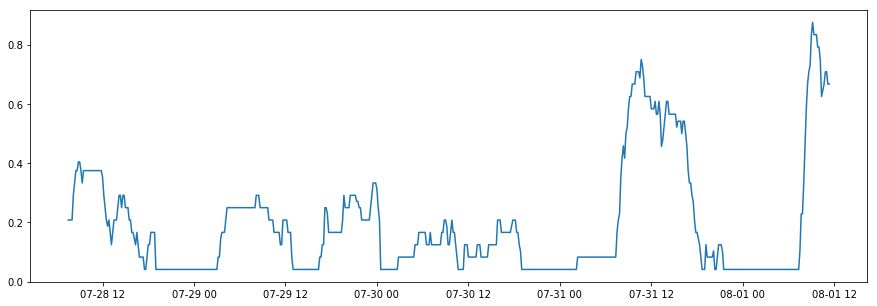

In [38]:
station = 12001
time_ts = "2017-07-28 07:30:00"
full = 600
data = df[(df.station == station) & (df.ts >= time_ts)].head(full)
plt.subplots(1 ,figsize=(15,5))
plt.plot(data.ts, data.probability)

In [31]:
from numpy import fft
def fourierExtrapolation(x, segments, harmo):
    n = x.size
    n_harm = round((n * harmo / 100) -0.5) # number of harmonics in model
    print(n_harm)
    t = np.arange(0, n)
    p = np.polyfit(t, x, 2)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + segments)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

In [32]:
def plot_fourrier(data,station, segments=5, harmo=10, return_df=False):
    
    lags = 550
    my_wine = data.loc[(data.station == station)].copy()
    
    X1 = my_wine[:-segments].tail(lags).copy()
    X2 = my_wine[-segments:].tail(lags).copy()
    
    extrapolation = fourierExtrapolation(X1.probability, segments, harmo)
    
    X1['fourrier'] = extrapolation[:-segments]
    X2['fourrier'] = extrapolation[-segments:]
    
    #plot
    fig, (axis1) = plt.subplots(1 ,figsize=(15,5))
    # Axe 1
    axis1.plot(X1.ts, X1.probability, '-', label='Historical')
    axis1.plot(X2.ts, X2.probability, '-', label='Reality')
    axis1.plot(X1.ts, X1.fourrier, '-', label='fourrier Train')
    axis1.plot(X2.ts, X2.fourrier, '-', label='fourrier extrapolation')
    
    plt.legend(loc='best')
    #plt.title(title)
    
    if return_df is True:
        return my_wine

54


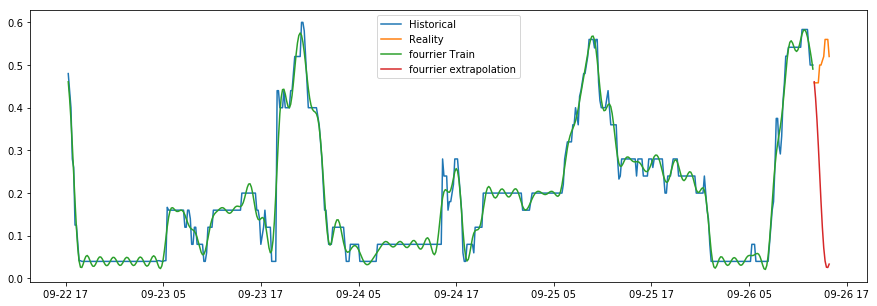

In [33]:
lol = plot_fourrier(df, station=12001, segments=12, harmo=10, return_df=True)

In [194]:
ok = fourierExtrapolation(lol.probability, segments=10, harmo=5)
len(ok)

573


11477

In [195]:
lol['ff'] = ok[0:len(lol)]

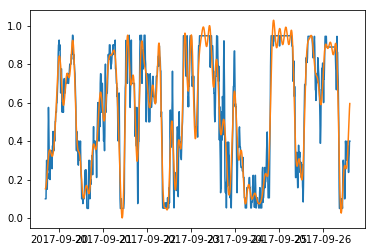

In [199]:
lag = 1000
plt.plot(lol.ts.tail(lag), lol.probability.tail(lag))
plt.plot(lol.ts.tail(lag), lol.ff.tail(lag))

In [179]:
ok

array([ 0.32282496,  0.32820109,  0.33357722,  0.33895335,  0.34432948,
        0.34970561,  0.35508174,  0.36045787,  0.365834  ,  0.37121013,
        0.37658626,  0.38196239,  0.38733852,  0.39271465,  0.39809078,
        0.40346691,  0.40884304,  0.41421917,  0.4195953 ,  0.42497142])

In [176]:
ok

array([ 0.77140794,  0.8524127 ,  0.86706836, ...,  0.26172551,
        0.16631123,  0.11497797])

In [171]:
lol['ff'] = ok

11467

In [150]:
len(ok)

11460

In [151]:
len(lol)

11450

In [144]:
fft.fft(lol.probability)[0:2]

array([ 5072.94970184 +0.j        ,  -331.07366223-82.17605142j])

In [137]:
lol.tail()

,station,ts,bikes,stands,is_open,day,hour,minute,probability,date,fft
22928,1002,2017-09-26 14:10:00,5.0,17.0,1.0,1,14,10,0.227273,2017-09-26,(-171.788087592+87.1589375286j)
22929,1002,2017-09-26 14:20:00,2.0,19.5,1.0,1,14,20,0.093023,2017-09-26,(-72.7384019554-121.274762818j)
22930,1002,2017-09-26 14:30:00,2.0,20.0,1.0,1,14,30,0.090909,2017-09-26,(-210.787479074+182.78960152j)
22931,1002,2017-09-26 14:40:00,3.0,19.0,1.0,1,14,40,0.136364,2017-09-26,(-5.05692277419+0.000912249385151j)
22932,1002,2017-09-26 14:50:00,6.0,16.0,1.0,1,14,50,0.272727,2017-09-26,(-331.073662233+82.1760514231j)


2017-11-10 14:37:20,462 [14571] WARNING  py.warnings: /Users/babou/anaconda/envs/python3DS/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)



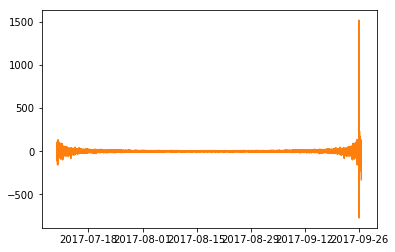

In [136]:
plt.plot(lol[120:].ts, lol[120:].probability)
plt.plot(lol[120:].ts, lol[120:].fft)

In [79]:
data = df[df.station == 1001]

In [80]:
data.head()

,station,ts,bikes,stands,is_open,day,hour,minute,probability,date
0,1001,2017-07-09 00:00:00,15.0,1.0,1.0,6,0,0,0.93750,2017-07-09
1,1001,2017-07-09 00:10:00,15.0,1.0,1.0,6,0,10,0.93750,2017-07-09
2,1001,2017-07-09 00:20:00,14.5,1.5,1.0,6,0,20,0.90625,2017-07-09
3,1001,2017-07-09 00:30:00,14.5,1.5,1.0,6,0,30,0.90625,2017-07-09
4,1001,2017-07-09 00:40:00,11.5,4.5,1.0,6,0,40,0.71875,2017-07-09


In [81]:
lol = fft.rfft(data.probability)

In [82]:
data.shape

(11466, 10)

In [83]:
x = data.probability

In [86]:
x[0:5]

0    0.93750
1    0.93750
2    0.90625
3    0.90625
4    0.71875
Name: probability, dtype: float64

In [96]:
n = x.size
n_harm = 3                     # number of harmonics in model
t = np.arange(0, n)
p = np.polyfit(t, x, 2)         # find linear trend in x
x_notrend = x - p[0] * t        # detrended x
x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
f = fft.fftfreq(n)              # frequencies
indexes = list(range(n))

In [95]:
range(2005 - 3, 2005 + 4, 1)

range(2002, 2009)

This is the final dataset. For further prediction, I could add some weather forecasts data to these features.

## Prediction

Let's select a time window (start, stop) to a single prediction.

* Two weeks of data for training
* Predict the 'probability' for the next 30 minutes and 1 hour for every station.
* Split the dataset into train and test dataset
* Compute the RMSE (Root Mean Squared Error) between the observations (i.e. probability) and the predicted values

In [107]:
start = pd.Timestamp("2017-08-01T02:00:00") # Tuesday
predict_date = pd.Timestamp("2017-09-22T09:00:00") # wednesday
# predict the next 30 minutes
freq = '12H'
# number of predictions at 'predict_date'.
# Here, the next 30 minutes and the next hour (30 minutes + 30 minutes).
# If you want to predict the next 3 hours, every 30 minutes, thus set periods=6
periods = 1

In [108]:
#train_X, train_Y, test_X, test_Y  
#X, y 
train_X, train_Y, test_X, test_Y  = prepare_data_for_training(df,
                                 predict_date,
                                 freq=freq,
                                 start=start,
                                 periods=periods,
                                 observation='probability',
                                 #how=None
                                )

2017-11-10 17:46:59,014 [16482] INFO     prediction: prepare data for training
2017-11-10 17:46:59,022 [16482] INFO     prediction: Get summer holiday features
2017-11-10 17:47:27,641 [16482] INFO     prediction: Get public holiday features
2017-11-10 17:47:47,038 [16482] INFO     prediction: compute delta with  public holiday on '5' days
2017-11-10 17:47:50,293 [16482] INFO     prediction: Get cluster station features
2017-11-10 17:47:51,319 [16482] INFO     prediction: Get Geo cluster station features
2017-11-10 17:47:52,082 [16482] INFO     prediction: Get ratio station geo cluster open by time
2017-11-10 17:47:55,342 [16482] INFO     prediction: sort values (station, ts)
2017-11-10 17:47:58,714 [16482] INFO     prediction: compute the future availability at '12H'
2017-11-10 17:47:59,404 [16482] INFO     prediction: merge data with the future availability
2017-11-10 17:48:56,217 [16482] INFO     prediction: availability label as values
2017-11-10 17:48:59,712 [16482] INFO     predic

In [90]:
def bikes_probability(df):
    df['probability'] = df['bikes'] / (df['bikes'] + df['stands'])
    return df

In [91]:
# TO DELETE
train_X['y'] = train_Y 

In [92]:
train_X = train_X.reset_index()
train_X = train_X.sort_values(['station', 'ts'])

In [97]:
train_X.head(10)

,ts,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,...,was_recently_open,total_stand,filling_station_by_geo_cluster,paa,sax,paa_minus_sax,paa_multi_sax,paa_ratio_sax,y,probability
0,2017-08-01 02:00:00,1001,11.0,5.0,1.0,1,2,0,1,0,...,1.0,16.0,0.363962,0.709375,0.728420,-0.019045,0.516723,0.973854,0.7500,0.68750
339,2017-08-01 02:10:00,1001,11.0,5.0,1.0,1,2,10,1,0,...,2.0,16.0,0.363962,0.709375,0.724056,-0.014681,0.513627,0.979725,0.6875,0.68750
678,2017-08-01 02:20:00,1001,11.5,4.5,1.0,1,2,20,1,0,...,3.0,16.0,0.363962,0.709375,0.719691,-0.010316,0.510531,0.985666,0.6875,0.71875
1017,2017-08-01 02:30:00,1001,12.0,4.0,1.0,1,2,30,1,0,...,4.0,16.0,0.361244,0.709375,0.715326,-0.005951,0.507435,0.991680,0.6250,0.75000
1356,2017-08-01 02:40:00,1001,12.0,4.0,1.0,1,2,40,1,0,...,5.0,16.0,0.352029,0.709375,0.710961,-0.001586,0.504338,0.997769,0.6250,0.75000
1695,2017-08-01 02:50:00,1001,12.0,4.0,1.0,1,2,50,1,0,...,6.0,16.0,0.352449,0.709375,0.706597,0.002778,0.501242,1.003932,0.6250,0.75000
2034,2017-08-01 03:00:00,1001,12.0,4.0,1.0,1,3,0,1,0,...,7.0,16.0,0.348657,0.709375,0.702232,0.007143,0.498146,1.010172,0.5625,0.75000
2373,2017-08-01 03:10:00,1001,11.0,5.0,1.0,1,3,10,1,0,...,8.0,16.0,0.337313,0.709375,0.697867,0.011508,0.495050,1.016490,0.5625,0.68750
2712,2017-08-01 03:20:00,1001,11.0,5.0,1.0,1,3,20,1,0,...,9.0,16.0,0.336516,0.709375,0.693503,0.015872,0.491953,1.022887,0.6250,0.68750
3051,2017-08-01 03:30:00,1001,10.0,6.0,1.0,1,3,30,1,0,...,10.0,16.0,0.335322,0.709375,0.689138,0.020237,0.488857,1.029366,0.6250,0.62500


In [96]:
train_X = bikes_probability(train_X)

In [98]:
train_X['prob_shit'] = train_X.groupby(['station'])['probability'].apply(lambda x: x.shift(1))
train_X['prob_diff'] = np.abs(train_X['prob_shit'] - train_X['probability'])
train_X['prob_diff'] = train_X['prob_diff'].fillna(0)

In [99]:
bias=0.5
train_X['prob_outlier'] = 0
train_X.loc[train_X['prob_diff'] >= bias, 'prob_outlier'] = 1

In [100]:
train_X[train_X.prob_outlier == 1].tail()

,ts,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,...,paa,sax,paa_minus_sax,paa_multi_sax,paa_ratio_sax,y,probability,prob_shit,prob_diff,prob_outlier
2112982,2017-09-13 08:40:00,11001,15.0,2.0,1.0,2,8,40,0,0,...,0.749346,0.733808,0.015539,0.549876,1.021176,0.941176,0.882353,0.055556,0.826797,1
2162137,2017-09-14 08:50:00,11001,12.0,6.0,1.0,3,8,50,0,0,...,0.327778,0.342992,-0.015214,0.112425,0.955642,0.666667,0.666667,0.166667,0.500000,1
2376046,2017-09-18 18:00:00,11001,13.0,5.0,1.0,0,18,0,0,0,...,0.205556,0.225157,-0.019601,0.046282,0.912944,0.722222,0.722222,0.111111,0.611111,1
61018,2017-08-02 07:50:00,12001,17.0,7.0,1.0,2,7,50,1,0,...,0.135417,0.164710,-0.029293,0.022304,0.822151,0.958333,0.708333,0.208333,0.500000,1
2404864,2017-09-19 08:10:00,12001,20.0,5.0,1.0,1,8,10,0,0,...,0.630667,0.622406,0.008260,0.392531,1.013272,0.800000,0.800000,0.240000,0.560000,1


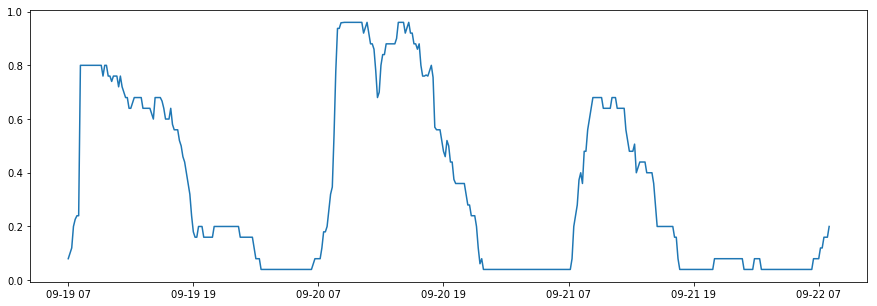

In [105]:
station = 12001
time_ts = "2017-09-19 07:00:00"
full = 600
data = train_X[(train_X.station == station) & (train_X.ts >= time_ts)].head(full)
plt.subplots(1 ,figsize=(15,5))
plt.plot(data.ts, data.probability)

In [106]:
data.head(10)

,ts,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,...,paa,sax,paa_minus_sax,paa_multi_sax,paa_ratio_sax,y,probability,prob_shit,prob_diff,prob_outlier
2402491,2017-09-19 07:00:00,12001,2.000000,23.000000,1.0,1,7,0,0,0,...,0.092000,0.099875,-0.007875,0.009189,0.921151,0.24,0.080000,0.080000,0.000000,0
2402830,2017-09-19 07:10:00,12001,2.500000,22.500000,1.0,1,7,10,0,0,...,0.092000,0.105959,-0.013959,0.009748,0.868258,0.80,0.100000,0.080000,0.020000,0
2403169,2017-09-19 07:20:00,12001,3.000000,22.000000,1.0,1,7,20,0,0,...,0.092000,0.112044,-0.020044,0.010308,0.821109,0.80,0.120000,0.100000,0.020000,0
2403508,2017-09-19 07:30:00,12001,5.000000,20.000000,1.0,1,7,30,0,0,...,0.092000,0.118128,-0.026128,0.010868,0.778817,0.80,0.200000,0.120000,0.080000,0
2403847,2017-09-19 07:40:00,12001,5.666667,19.333333,1.0,1,7,40,0,0,...,0.630667,0.604153,0.026513,0.381019,1.043885,0.80,0.226667,0.200000,0.026667,0
2404186,2017-09-19 07:50:00,12001,6.000000,19.000000,1.0,1,7,50,0,0,...,0.630667,0.610238,0.020429,0.384857,1.033477,0.80,0.240000,0.226667,0.013333,0
2404525,2017-09-19 08:00:00,12001,6.000000,19.000000,1.0,1,8,0,0,0,...,0.630667,0.616322,0.014345,0.388694,1.023275,0.80,0.240000,0.240000,0.000000,0
2404864,2017-09-19 08:10:00,12001,20.000000,5.000000,1.0,1,8,10,0,0,...,0.630667,0.622406,0.008260,0.392531,1.013272,0.80,0.800000,0.240000,0.560000,1
2405203,2017-09-19 08:20:00,12001,20.000000,5.000000,1.0,1,8,20,0,0,...,0.630667,0.628491,0.002176,0.396368,1.003463,0.80,0.800000,0.800000,0.000000,0
2405542,2017-09-19 08:30:00,12001,20.000000,5.000000,1.0,1,8,30,0,0,...,0.630667,0.634575,-0.003908,0.400205,0.993841,0.80,0.800000,0.800000,0.000000,0


### Rolling Validation

In [199]:
def fit_rolling(train_X, train_Y, test_X, test_Y, param, num_round=25):
    """Train the xgboost model

    Return the booster trained model
    """
    # param = {'objective': 'reg:linear'}

    #if param
    #param = {'objective': 'reg:logistic'}
    #param['eta'] = 0.2
    #param['max_depth'] = 4 # 6 original
    #param['silent'] = 1
    #param['nthread'] = 4
    # used num_class only for classification (e.g. a level of availability)
    # param = {'objective': 'multi:softmax'}
    # param['num_class'] = train_Y.nunique()
    xg_train = xgb.DMatrix(train_X, label=train_Y)
    xg_test = xgb.DMatrix(test_X, label=test_Y)
    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    evals_result = {}
    bst = xgb.train(param, xg_train, num_round, watchlist, evals_result=evals_result)
    return bst, evals_result

In [200]:
result = [] # All macro result by fold
learning_progress = {} # micro result by fold
pred_serie = np.full(X.shape[0], np.nan) # Store pred during the rolling windows
fold_serie = np.full(X.shape[0], np.nan) # Store fold during the rolling windows

tscv = TimeSeriesSplit(n_splits=3)
for (train_index, test_index), k in zip (tscv.split(X), range(1, tscv.n_splits+1, 1)):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    print("Train : ")
    print(X_train.index.min())
    print(X_train.index.max())
    print(len(X_train))
    print("Test  : ")
    print(X_test.index.min())
    print(X_test.index.max())
    print(len(X_test))
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Split tranning for XGB
    X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train,
                                              test_size=0.33, random_state=42)
    
    # Adding Meteo features
    # Learning for Xgb
    X_tr = get_weather(X_tr, how='learning')
    X_te = get_weather(X_te, how='forecast', freq=freq)
    
    X_test = get_weather(X_test, how='forecast', freq=freq)
    
    # Learning XGB$
    # the 'booster'
    param ={"objective": "reg:logistic",
              "booster" : "gbtree",
              "eta": 0.2,
              "max_depth": 9,
              "silent": 1,
              "seed": 42}
    bst, evals_result = fit_rolling(X_tr, y_tr, X_te, y_te, param, num_round=60)
    
    pred = prediction(bst, X_test, y_test)
    rmse = np.sqrt(np.mean((pred - y_test)**2))
    
    pred_serie[test_index] = pred
    fold_serie[test_index] = k
    
    learning_progress[tscv.n_splits] = evals_result
    
    result.append({'fold' : k,
                  'train_min_date' : X_train.index.min(),
                  'train_max_date' : X_train.index.max(),
                   'len_train' : len(X_train),
                  'test_min_date' : X_test.index.min(),
                  'test_max_date' : X_test.index.max(),
                   'len_test' : len(X_test),
                  'rmse_train' : evals_result['train']['rmse'][-1],
                  'rmse_test' : evals_result['test']['rmse'][-1],
                  'rmse_validation' : rmse})
    print("---------------------------------------------")
df_result = pd.DataFrame(result)
X['pred'] = pred_serie
X['fold'] = fold_serie

Train : 
2017-08-01 02:00:00
2017-08-14 03:30:00
637746
Test  : 
2017-08-14 03:30:00
2017-08-27 05:00:00
637743
[0]	train-rmse:0.264255	test-rmse:0.264303
[1]	train-rmse:0.221977	test-rmse:0.222264
[2]	train-rmse:0.189725	test-rmse:0.190373
[3]	train-rmse:0.165352	test-rmse:0.166272
[4]	train-rmse:0.147173	test-rmse:0.148437
[5]	train-rmse:0.1338	test-rmse:0.135328
[6]	train-rmse:0.124139	test-rmse:0.125938
[7]	train-rmse:0.117231	test-rmse:0.119253
[8]	train-rmse:0.11232	test-rmse:0.114584
[9]	train-rmse:0.10872	test-rmse:0.111141
[10]	train-rmse:0.10619	test-rmse:0.108822
[11]	train-rmse:0.104195	test-rmse:0.106988
[12]	train-rmse:0.102838	test-rmse:0.10575
[13]	train-rmse:0.101826	test-rmse:0.10483
[14]	train-rmse:0.100643	test-rmse:0.103791
[15]	train-rmse:0.100073	test-rmse:0.10332
[16]	train-rmse:0.099484	test-rmse:0.102878
[17]	train-rmse:0.099007	test-rmse:0.102525
[18]	train-rmse:0.098585	test-rmse:0.102211
[19]	train-rmse:0.097977	test-rmse:0.10173
[20]	train-rmse:0.097421	te

[59]	train-rmse:0.091773	test-rmse:0.095415
---------------------------------------------


In [201]:
df_result.head()

,fold,len_test,len_train,rmse_test,rmse_train,rmse_validation,test_max_date,test_min_date,train_max_date,train_min_date
0,3,637743,637746,0.092354,0.083158,0.096094,2017-08-27 05:00:00,2017-08-14 03:30:00,2017-08-14 03:30:00,2017-08-01 02:00:00
1,3,637743,1275489,0.092316,0.086886,0.105826,2017-09-09 06:30:00,2017-08-27 05:00:00,2017-08-27 05:00:00,2017-08-01 02:00:00
2,3,637743,1913232,0.095415,0.091773,0.109602,2017-09-22 08:00:00,2017-09-09 06:30:00,2017-09-09 06:30:00,2017-08-01 02:00:00


In [202]:
X['y'] = y

In [203]:
X.tail()

,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,public_holiday_count,...,total_stand,filling_station_by_geo_cluster,paa,sax,paa_minus_sax,paa_multi_sax,paa_ratio_sax,pred,fold,y
ts,,,,,,,,,,,,,,,,,,,,,
2017-09-22 08:00:00,11001,1.0,17.0,1.0,4,8,0,0,0,0.0,...,18.0,0.359069,0.088889,0.087707,0.001182,0.007796,1.013481,0.136377,3.0,0.222222
2017-09-22 08:00:00,11002,16.0,4.0,1.0,4,8,0,0,0,0.0,...,20.0,0.386667,0.735000,0.736834,-0.001834,0.541573,0.997511,0.590673,3.0,0.600000
2017-09-22 08:00:00,11003,17.0,3.0,1.0,4,8,0,0,0,0.0,...,20.0,0.359069,0.865000,0.868574,-0.003574,0.751316,0.995885,0.813607,3.0,0.800000
2017-09-22 08:00:00,12001,5.0,20.0,1.0,4,8,0,0,0,0.0,...,25.0,0.340893,0.202000,0.200820,0.001180,0.040566,1.005878,0.363851,3.0,0.420000
2017-09-22 08:00:00,12002,2.0,18.0,1.0,4,8,0,0,0,0.0,...,20.0,0.340893,0.055000,0.056097,-0.001097,0.003085,0.980447,0.112957,3.0,0.050000


In [239]:
#import matplotlib.ticker as ticker
import matplotlib.dates as mdates

def plot_station_pred(result, station):
    """Plot available bikes and bike stands for a given station"""
    
    data = result[result.station == station].copy()
    
    nb_flod = data.fold.nunique()
    
    fig, axarr = plt.subplots(nb_flod ,figsize=(17,10))
    
    for i in range(0, nb_flod):
        fold_data = data[data.fold == i+1]
        rmse_fold = np.round(np.sqrt(np.mean((fold_data.pred - fold_data.y)**2)), 3)
        axarr[i].plot(fold_data[fold_data.is_open == 1].index, fold_data[fold_data.is_open == 1].y,
                      '-', label='Open', alpha=0.6)
        axarr[i].plot(fold_data[fold_data.is_open == 0].index, fold_data[fold_data.is_open == 0].y,
                      '-', label='Closed', alpha=0.6)
        axarr[i].plot(fold_data.index, fold_data.pred, 'r-', label='Prediction')
        axarr[i].set_title('Fold '+str(i+1)+' : RMSE '+str(rmse_fold), fontsize =25)
    
    ##ax = plt.gca()
    # set major ticks location every day
    ##ax.xaxis.set_major_locator(mdates.DayLocator())
    # set major ticks format
    ##ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n\n%a %d.%m.%Y'))
    # set minor ticks location every two hours
    ##ax.xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    # set minor ticks format
    ##ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
    ##plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)

    plt.legend(loc='best')
    fig.tight_layout()
#    print("TRAIN")
#    print(train.tail(5))
#    print("DATA")
#    print(data)

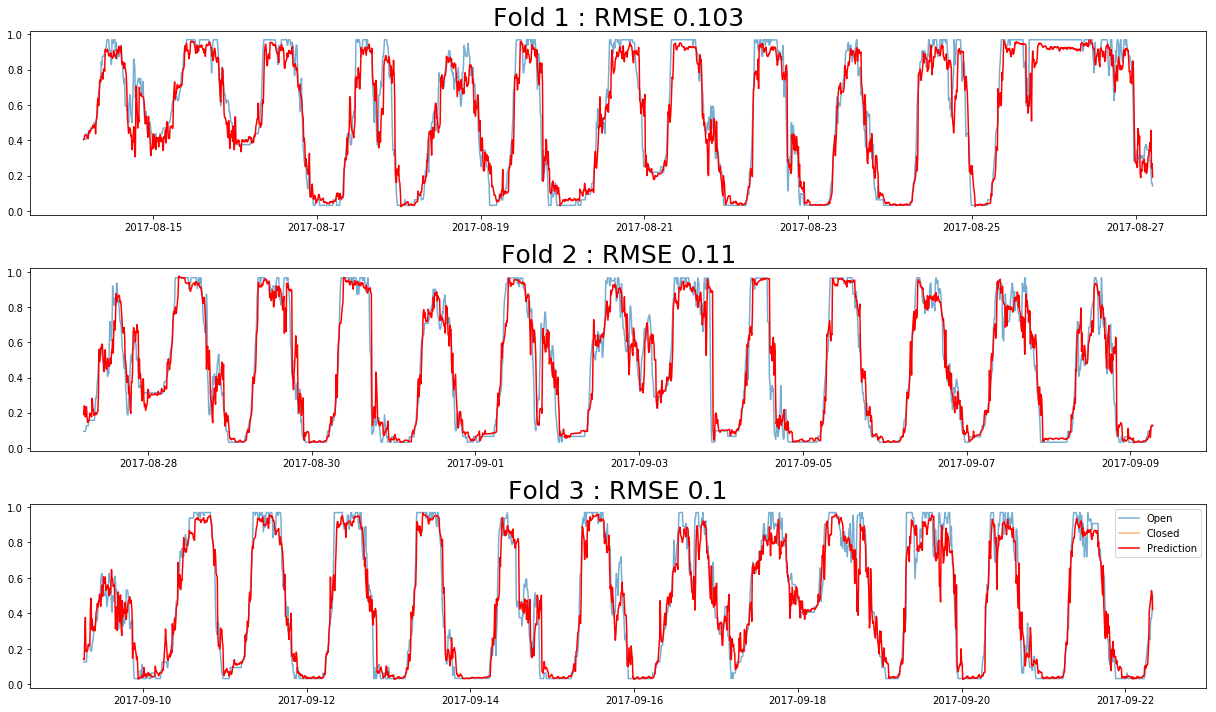

In [243]:
plot_station_pred(X, station=2005)

### Single Validation

In [109]:
train_X[train_X.index == "2017-08-12"].head()

,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,public_holiday_count,...,cumsum_trend_inf,cumsum_trend_equal,was_recently_open,total_stand,filling_station_by_geo_cluster,paa,sax,paa_minus_sax,paa_multi_sax,paa_ratio_sax
ts,,,,,,,,,,,,,,,,,,,,,
2017-08-12,1001,15.0,1.0,1.0,5,0,0,1,0,3.0,...,0,9,24.0,16.0,0.593602,0.937500,0.936847,0.000653,0.878294,1.000697
2017-08-12,1002,8.0,14.0,1.0,5,0,0,1,0,3.0,...,0,0,24.0,22.0,0.593602,0.246247,0.262598,-0.016351,0.064664,0.937735
2017-08-12,1003,3.0,12.0,1.0,5,0,0,1,0,3.0,...,0,1,24.0,15.0,0.593602,0.233333,0.220063,0.013270,0.051348,1.060302
2017-08-12,1005,2.0,8.0,1.0,5,0,0,1,0,3.0,...,0,5,24.0,10.0,0.593602,0.220000,0.204111,0.015889,0.044904,1.077845
2017-08-12,1006,13.0,9.0,1.0,5,0,0,1,0,3.0,...,0,4,24.0,22.0,0.593602,0.590909,0.592541,-0.001632,0.350138,0.997246


In [110]:
print(train_X.index.min())
print(train_X.index.max())

2017-08-01 02:00:00
2017-09-21 21:00:00


In [111]:
test_X.index.unique()

DatetimeIndex(['2017-09-22 09:00:00', '2017-09-22 09:10:00',
               '2017-09-22 09:20:00', '2017-09-22 09:30:00',
               '2017-09-22 09:40:00', '2017-09-22 09:50:00',
               '2017-09-22 10:00:00', '2017-09-22 10:10:00',
               '2017-09-22 10:20:00', '2017-09-22 10:30:00',
               '2017-09-22 10:40:00', '2017-09-22 10:50:00',
               '2017-09-22 11:00:00', '2017-09-22 11:10:00',
               '2017-09-22 11:20:00', '2017-09-22 11:30:00',
               '2017-09-22 11:40:00', '2017-09-22 11:50:00',
               '2017-09-22 12:00:00', '2017-09-22 12:10:00',
               '2017-09-22 12:20:00', '2017-09-22 12:30:00',
               '2017-09-22 12:40:00', '2017-09-22 12:50:00',
               '2017-09-22 13:00:00', '2017-09-22 13:10:00',
               '2017-09-22 13:20:00', '2017-09-22 13:30:00',
               '2017-09-22 13:40:00', '2017-09-22 13:50:00',
               '2017-09-22 14:00:00', '2017-09-22 14:10:00',
               '2017-09-

In [112]:
# Observation with a shift of T+30 minutes in comparison to train_X.
# This is the 'future' availability used for traning.
train_Y.head()

ts
2017-08-01 02:00:00    0.062500
2017-08-01 02:00:00    0.159091
2017-08-01 02:00:00    0.066667
2017-08-01 02:00:00    0.900000
2017-08-01 02:00:00    0.090909
Name: future, dtype: float64

The `fit` function create some data structure for the XGBoost from the train and test DataFrames (i.e. `xgb.DMatrix)`, configure the model and launch it with the `objective: 'reg:logistic'`. It's a regression, not a classification.

In [113]:
# Spliting train in learning / validation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, 
                                                    test_size=0.33, random_state=42)

In [114]:
X_train.tail()

,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,public_holiday_count,...,cumsum_trend_inf,cumsum_trend_equal,was_recently_open,total_stand,filling_station_by_geo_cluster,paa,sax,paa_minus_sax,paa_multi_sax,paa_ratio_sax
ts,,,,,,,,,,,,,,,,,,,,,
2017-08-03 08:10:00,3102,1.0,15.0,1.0,3,8,10,1,0,0.0,...,0,2,24.0,16.0,0.419255,0.106250,0.102069,0.004181,0.010845,1.040965
2017-09-04 18:10:00,5002,11.0,7.0,1.0,0,18,10,0,0,0.0,...,0,5,24.0,18.0,0.371479,0.546032,0.555989,-0.009957,0.303587,0.982092
2017-09-18 08:20:00,10030,4.0,14.0,1.0,0,8,20,0,0,0.0,...,0,0,24.0,18.0,0.466806,0.083333,0.109180,-0.025847,0.009098,0.763263
2017-09-15 17:50:00,6036,2.5,19.5,1.0,4,17,50,0,0,0.0,...,8,0,24.0,22.0,0.324809,0.275476,0.272429,0.003047,0.075048,1.011183
2017-09-15 13:00:00,1035,6.0,10.0,1.0,4,13,0,0,0,0.0,...,0,4,24.0,16.0,0.416568,0.356250,0.365406,-0.009156,0.130176,0.974942


In [115]:
# Adding Meteo features
# Learning for Xgb
X_train = get_weather(X_train, how='learning')
X_test = get_weather(X_test, how='forecast', freq=freq)

# Value in futur
test_X = get_weather(test_X, how='forecast', freq=freq)

In [116]:
# the 'booster'
param ={"objective": "reg:logistic",
          "booster" : "gbtree",
          "eta": 0.2,
          "max_depth": 9,
          "silent": 1,
          "seed": 42}
bst = fit(X_train, y_train, X_test, y_test, param, num_round=60)

2017-11-10 17:52:44,559 [16482] INFO     prediction: fit


[0]	train-rmse:0.299387	test-rmse:0.299541
[1]	train-rmse:0.281258	test-rmse:0.281638
[2]	train-rmse:0.268465	test-rmse:0.268948
[3]	train-rmse:0.259271	test-rmse:0.25986
[4]	train-rmse:0.252185	test-rmse:0.252879
[5]	train-rmse:0.246616	test-rmse:0.247431
[6]	train-rmse:0.242269	test-rmse:0.243167
[7]	train-rmse:0.239213	test-rmse:0.240304
[8]	train-rmse:0.236646	test-rmse:0.237851
[9]	train-rmse:0.234569	test-rmse:0.235975
[10]	train-rmse:0.232764	test-rmse:0.234282
[11]	train-rmse:0.230956	test-rmse:0.232578
[12]	train-rmse:0.22945	test-rmse:0.231146
[13]	train-rmse:0.227694	test-rmse:0.229514
[14]	train-rmse:0.22635	test-rmse:0.228269
[15]	train-rmse:0.225533	test-rmse:0.227546
[16]	train-rmse:0.224274	test-rmse:0.226434
[17]	train-rmse:0.22331	test-rmse:0.225585
[18]	train-rmse:0.222076	test-rmse:0.22448
[19]	train-rmse:0.22153	test-rmse:0.224072
[20]	train-rmse:0.220962	test-rmse:0.223646
[21]	train-rmse:0.219944	test-rmse:0.222707
[22]	train-rmse:0.21889	test-rmse:0.22178
[23]	t

In [31]:
X_test.columns

Index(['station', 'bikes', 'stands', 'is_open', 'day', 'hour', 'minute',
       'is_holiday', 'public_holiday', 'public_holiday_count', 'cluster',
       'station_cluster_geo', 'ratio_station_geo_cluster_open',
       'bikes_shift_1Hmin', 'cumsum_trend_sup', 'cumsum_trend_inf',
       'cumsum_trend_equal', 'was_recently_open', 'total_stand',
       'filling_station_by_geo_cluster', 'paa', 'sax', 'paa_minus_sax',
       'paa_multi_sax', 'paa_ratio_sax', 'temp', 'humidity', 'weather_desc'],
      dtype='object')

In [32]:
test_X.columns

Index(['station', 'bikes', 'stands', 'is_open', 'day', 'hour', 'minute',
       'is_holiday', 'public_holiday', 'public_holiday_count', 'cluster',
       'station_cluster_geo', 'ratio_station_geo_cluster_open',
       'bikes_shift_1Hmin', 'cumsum_trend_sup', 'cumsum_trend_inf',
       'cumsum_trend_equal', 'was_recently_open', 'total_stand',
       'filling_station_by_geo_cluster', 'paa', 'sax', 'paa_minus_sax',
       'paa_multi_sax', 'paa_ratio_sax', 'temp', 'humidity', 'weather_desc'],
      dtype='object')

In [119]:
# compute the prediction from test_* (Validation)
pred = prediction(bst, test_X, test_Y)

In [120]:
pred[:5]

array([ 0.81689173,  0.92807096,  0.80969596,  0.82540518,  0.75648701], dtype=float32)

In [121]:
test_Y[:5].tolist()

[0.9375, 0.9565217391304348, 0.8, 0.9, 0.7272727272727273]

In [122]:
print("Number of predictions: {}".format(len(pred)))

Number of predictions: 24747


In [123]:
# Compute the RMSE
rmse = np.sqrt(np.mean((pred - test_Y)**2))
rmse

0.23358671749310925

In [42]:
# New periode time

#start = pd.Timestamp("2017-08-01T00:10:00") # Tuesday
#predict_date = pd.Timestamp("2017-09-22T09:00:00") # wednesday
# predict the next 30 minutes
#freq = '1H'
# number of predictions at 'predict_date'.
# Here, the next 30 minutes and the next hour (30 minutes + 30 minutes).
# If you want to predict the next 3 hours, every 30 minutes, thus set periods=6
#periods = 1

# train-rmse:0.134421	test-rmse:0.134516 / 0.14425 : original : max_depth 6 / num_round = 25
# train-rmse:0.133858	test-rmse:0.133971 / 0.14436 : shift features
# train-rmse:0.132937	test-rmse:0.133034 / 0.14285 : Trending features
# train-rmse:0.132937	test-rmse:0.133034 / 0.14285 : Was recently open features (No improve at all, no use of features
# train-rmse:0.126300	test-rmse:0.127283 / 0.13869 : Idem max_dept 8 / num_round = 60. Stil no use of recently_open
# train-rmse:0.123439	test-rmse:0.124447 / 0.13477 : Cluster lyon station activite
# train-rmse:0.122884	test-rmse:0.123860 / 0.13571 : Cluster Lyon geo
# train-rmse:0.122716	test-rmse:0.123831 / 0.13432 : filling_station_by_geo_cluster & Total stand
# train-rmse:0.105716	test-rmse:0.107058 / 0.10607 : Add PAA tranformation (segments = 10 )
# train-rmse:0.104273	test-rmse:0.105701 / 0.10400 : Add Sax transformation (segments=10, symbols=8)
# train-rmse:0.104693	test-rmse:0.106081 / 0.10391 : Add public_holiday 
# train-rmse:0.104431	test-rmse:0.105907 / 0.10435 : add public_holiday_count (delta from x last holiday)
# train-rmse:0.104448	test-rmse:0.105840 / 0.10461 : Add summer holiday
# train-rmse:0.104113	test-rmse:0.105526 / 0.10457 : absolute public_holiday_count
# train-rmse:0.104328	test-rmse:0.106016 / 0.09623 : start time = "2017-08-01T02:00:00" (old "2017-08-01T00:10:00") for forecast weather matching
# train-rmse:0.104084	test-rmse:0.106086 / 0.09596 : Add weather ['temp', 'humidity', 'weather_desc']
# train-rmse:0.104084	test-rmse:0.106086 / 0.09596 : add ratio_station_open by time (not use)
# train-rmse:0.101491	test-rmse:0.104886 / 0.09667 : max_depth = 9 (ratio_station_open still not use)
# train-rmse:0.101491	test-rmse:0.104886 / 0.09667 : drop ratio_station_open (Features add nothing)
# train-rmse:0.101676	test-rmse:0.105003 / 0.09540 : add ratio_station_geo_cluster_open features
# train-rmse:0.101713	test-rmse:0.104963 / 0.09545 : Fix minutes
# train-rmse:0.101713	test-rmse:0.104963 / 0.09545 : [X] Binned hours of day (7 grp) (Didn't use it)
# train-rmse:0.101835	test-rmse:0.105203 / 0.09624 : [X]"subsample" : 0.85
# train-rmse:0.101666	test-rmse:0.105105 / 0.09575 : [X] Binned hours of day (5 grp) use it but not worth
# train-rmse:0.095662	test-rmse:0.099130 / 0.08941 : Interaction features with paa & sax

In [43]:
#start = pd.Timestamp("2017-07-11T00:00:00") # Tuesday
#predict_date = pd.Timestamp("2017-07-26T10:00:00") # wednesday
# predict the next 30 minutes
#freq = '3OT'
# number of predictions at 'predict_date'.
# Here, the next 30 minutes and the next hour (30 minutes + 30 minutes).
# If you want to predict the next 3 hours, every 30 minutes, thus set periods=6
#periods = 2

#0.092800 original direct on test set

# Learning on : 501686 rows
# Testing on : 247100 rows
# Validation on : 2366 rows

## train / test / validation : comment
# train-rmse:0.087365	test-rmse:0.091362 / 0.09200 : 
# train-rmse:0.086774	test-rmse:0.090772 / 0.09222 :  shift 30 min
# train-rmse:0.086267	test-rmse:0.091045 / 0.092387 : trending KPI
# train-rmse:0.084771	test-rmse:0.089825 / 0.091426 : Cluster Lyon station activité
# train-rmse:0.084847	test-rmse:0.089818 / 0.091285 : was recently open
# train-rmse:0.083754	test-rmse:0.089106 / 0.091335 : Cluster Lyon geo
# train-rmse:0.08413	test-rmse:0.089307 / 0.0915887 : Cluster Lyon geo implement (Checking problem with -1)
# train-rmse:0.084369	test-rmse:0.089433 / 0.091028 : Fix nan was recently open with min_periods=1
# train-rmse:0.083312	test-rmse:0.089216 / 0.091014 : Adding total_stand; total_stand_geo_cluster; bikes_shift_30Tmin_geo_cluster; filling_station_by_geo_cluster
# train-rmse:0.083598	test-rmse:0.089433 / 0.091099 : DROP total_stand (features in filling_bike_on_geo_cluster)
# train-rmse:0.083386	test-rmse:0.089155 / 0.091078 : DROP total_stand_geo_cluster (...)
# train-rmse:0.083296	test-rmse:0.089036 / 0.090905 : DROP bikes_shift_30Tmin_geo_cluster (...)
# train-rmse:0.08354	test-rmse:0.089057 / 0.090567 : [V] Keep only filling_station_by_geo_cluster
# train-rmse:0.083809	test-rmse:0.089234 / 0.090531 : [X] Chage recently open (0->24) to boolean 24->1 else 0 (1 si la station est ouverte depuis 4H par exemple)
# train-rmse:0.083872	test-rmse:0.089464 / 0.090993 : [X] filling_station and filling_station_minus_filling_geo_station
# train-rmse:0.083918	test-rmse:0.089440 / 0.09133  : [X] DROP filling_station
# train-rmse:0.085091	test-rmse:0.090080 / 0.091526 : [X] DROP Station for more general learning
# train-rmse:0.063492	test-rmse:0.069996 / 0.059212 : Add PAA & SAX transformation



In [44]:
#start = pd.Timestamp("2017-07-01T00:00:00") # 
#predict_date = pd.Timestamp("2017-07-27T16:00:00") # Thursday
# predict the next 30 minutes
#freq = '1H'
# number of predictions at 'predict_date'.
# Here, the next 30 minutes and the next hour (30 minutes + 30 minutes).
# If you want to predict the next 3 hours, every 30 minutes, thus set periods=6
#periods = 1

# train-rmse:0.113644	test-rmse:0.117976 / 0.17470 : Same as previous best run
# train-rmse:0.114026	test-rmse:0.118588 / 0.1756795 : adding paa (segment=20)
# train-rmse:0.113203	test-rmse:0.117770 / 0.175806 : adding paa (segment=6 - 1 hours)
# train-rmse:0.098235	test-rmse:0.103058 / 0.133363 : Fix Paa function (bad value before)
# train-rmse:0.097559	test-rmse:0.102510 / 0.132045 : Sax function (drop paa)
# train-rmse:0.096851	test-rmse:0.102011 / 0.130106 : PAA and SAX

In [45]:
# must install graphviz
# plot_tree(bst)

In [124]:
def plot_features_importance(bst):
    """
    Plot features importance for a xgboost model
    """
    df_importance = pd.DataFrame([bst.get_score()]).T.reset_index()
    df_importance.columns = ['features', 'importance']
    df_importance.sort_values('importance', ascending=0, inplace=True)
    plt.figure(figsize=(10, 6))
    sns.barplot('importance', 'features', data=df_importance)
    plt.xlabel('Relative importance')
    plt.ylabel('Features importance')

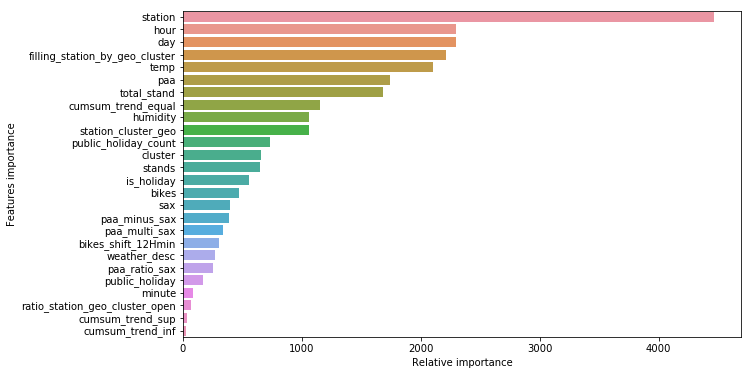

In [125]:
plot_features_importance(bst)

## Store the results

In [126]:
result = test_X.copy()
result['ts_future'] = test_Y.index.shift(1, freq=freq)

result['observation'] = test_Y.copy()
result['ts_future'] = test_Y.index.shift(1, freq=freq) ##??
result['prediction'] = pred
result['error'] = pred - test_Y
result['error_abs'] = np.abs(pred - test_Y)
result['relative_error'] = 100. * np.abs(pred - test_Y) / test_Y
result['quad_error'] = (pred - test_Y)**2
result.to_csv("prediction-freq-{}-{}.csv".format(freq, predict_date))

In [127]:
result.sort_values('error_abs', ascending=1).tail(10)

,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,public_holiday_count,...,temp,humidity,weather_desc,ts_future,observation,prediction,error,error_abs,relative_error,quad_error
ts,,,,,,,,,,,,,,,,,,,,,
2017-09-22 15:20:00,7024,13.500000,2.500000,1.0,4,15,20,0,0,0.0,...,21.58,48,1,2017-09-23 03:20:00,0.062500,0.777152,0.714652,0.714652,1143.443584,0.510728
2017-09-22 09:10:00,7023,1.000000,14.000000,1.0,4,9,10,0,0,0.0,...,5.38,79,0,2017-09-22 21:10:00,0.066667,0.795644,0.728978,0.728978,1093.466425,0.531408
2017-09-22 09:20:00,7023,1.000000,14.000000,1.0,4,9,20,0,0,0.0,...,5.38,79,0,2017-09-22 21:20:00,0.066667,0.797908,0.731242,0.731242,1096.862370,0.534714
2017-09-22 14:10:00,1032,16.666667,5.333333,1.0,4,14,10,0,0,0.0,...,21.58,48,1,2017-09-23 02:10:00,0.931818,0.191758,-0.740060,0.740060,79.421114,0.547689
2017-09-22 09:30:00,7023,1.000000,14.000000,1.0,4,9,30,0,0,0.0,...,5.38,79,0,2017-09-22 21:30:00,0.066667,0.808546,0.741879,0.741879,1112.818295,0.550384
2017-09-22 09:40:00,7023,1.000000,14.000000,1.0,4,9,40,0,0,0.0,...,5.38,79,0,2017-09-22 21:40:00,0.066667,0.810384,0.743718,0.743718,1115.576321,0.553116
2017-09-22 14:40:00,1001,5.000000,11.000000,1.0,4,14,40,0,0,0.0,...,21.58,48,1,2017-09-23 02:40:00,0.875000,0.131066,-0.743934,0.743934,85.021002,0.553437
2017-09-22 14:00:00,1001,5.000000,11.000000,1.0,4,14,0,0,0,0.0,...,21.58,48,1,2017-09-23 02:00:00,0.906250,0.123236,-0.783014,0.783014,86.401537,0.613111
2017-09-22 14:50:00,1001,5.000000,11.000000,1.0,4,14,50,0,0,0.0,...,21.58,48,1,2017-09-23 02:50:00,0.937500,0.143311,-0.794189,0.794189,84.713538,0.630737


In [128]:
trainning = train_X.copy()
trainning['y'] = train_Y 

In [129]:
result['proba'] = result['bikes'] / (result['bikes'] + result['stands'])

In [130]:
#trainning[trainning.station == 4005].tail(20)

In [131]:
#import matplotlib.ticker as ticker
import matplotlib.dates as mdates

def plot_station(result, trainning, station):
    """Plot available bikes and bike stands for a given station"""
    
    nb_row = 750
    train = trainning[trainning.station == station].tail(nb_row)
    data = result[result.station == station].copy()
    
    fig, ax = plt.subplots(figsize=(18,5))
    plt.plot(train[train.is_open == 1].index, train[train.is_open == 1].y, '-', label='Open', alpha=0.6)
    plt.plot(train[train.is_open == 0].index, train[train.is_open == 0].y, '-', label='Closed', alpha=0.6)
    #plt.plot(train.index, train.paa, '-', label='PAA', alpha=0.6)
    #plt.plot(train.index, train.sax, '-', label='SAX', alpha=0.6)
    plt.plot(data.index, data.observation, 'g-', label='Real')
    plt.plot(data.index, data.prediction, 'r-', label='Prediction')
    
    
    ax = plt.gca()
    # set major ticks location every day
    ax.xaxis.set_major_locator(mdates.DayLocator())
    # set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n\n%a %d.%m.%Y'))
    # set minor ticks location every two hours
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    # set minor ticks format
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)

    plt.legend(loc='best')
#    print("TRAIN")
#    print(train.tail(5))
#    print("DATA")
#    print(data)

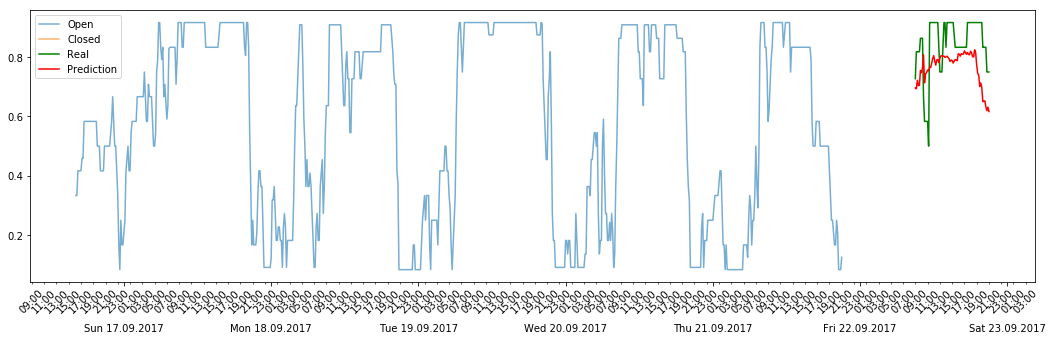

In [141]:
# Il semble que l'on est pas toute les données

plot_station(result, trainning, 7041)

In [133]:
result['total_stand'] = result['bikes'] + result['stands']
result['bikes_pred'] = np.round(result['total_stand'] * result['prediction'])
result['bikes_true'] = result['total_stand'] * result['observation']

In [134]:
from sklearn.metrics import mean_absolute_error

In [135]:
mean_absolute_error(result.bikes_true, result.bikes_pred)

3.6106218904582064

In [321]:
testing = result[result.station == 10113].copy()

In [326]:
testing.head()

,station,bikes,stands,is_open,day,hour,minute,cluster,station_cluster_geo,bikes_shift_30Tmin,...,observation,prediction,error,error_abs,relative_error,quad_error,bikes_pred,bikes_true,proba,shift_mean_3
ts,,,,,,,,,,,,,,,,,,,,,
2017-07-26 09:00:00,10113,7.0,15.000000,1.0,2,9,0,1,3,4.0,...,0.646154,0.427451,-0.218703,0.218703,33.846894,0.047831,9.0,14.215385,0.318182,0.318182
2017-07-26 09:10:00,10113,9.0,13.000000,1.0,2,9,0,1,3,4.0,...,0.690476,0.465008,-0.225468,0.225468,32.654032,0.050836,10.0,15.190476,0.409091,0.363636
2017-07-26 09:20:00,10113,7.0,15.000000,1.0,2,9,10,1,3,7.0,...,0.690476,0.386977,-0.303499,0.303499,43.955040,0.092112,9.0,15.190476,0.318182,0.348485
2017-07-26 09:30:00,10113,14.0,7.666667,1.0,2,9,20,1,3,9.0,...,0.714286,0.561054,-0.153232,0.153232,21.452458,0.023480,12.0,15.476190,0.646154,0.457809
2017-07-26 09:40:00,10113,14.5,6.500000,1.0,2,9,30,1,3,7.0,...,0.761905,0.553633,-0.208272,0.208272,27.335727,0.043377,12.0,16.000000,0.690476,0.551604


In [137]:
station_result = result.groupby('station')[['bikes_true','bikes_pred']].apply(lambda row: mean_absolute_error(row.bikes_true, row.bikes_pred))
station_result_df = pd.DataFrame(station_result).reset_index()
station_result_df.columns = ['station', 'mae']

In [138]:
station_result_df.sort_values('mae')

,station,mae
258,9043,0.438356
338,12002,0.520548
262,9051,0.547945
95,4001,0.657534
219,8024,0.752446
277,10024,0.756502
334,11001,0.821918
293,10049,0.853881
39,2025,0.856164
6,1013,0.863014


In [60]:
def plot_features(station, lag=-350):
    #station = 3002
    lol = testing[testing.station == station].copy()
    lag = -1200

    plt.figure(figsize=(18,6))
    plt.plot(lol.ts[lag:], lol.probability[lag:], "r-", alpha=0.6, label='Origin')
    plt.plot(lol.ts[lag:], lol.sax[lag:], "b-", alpha=0.7, label='sax')
    #plt.plot(lol.ts[lag:], lol.paa_2[lag:], "k-", alpha=0.7, label='paa_2')
    #plt.plot(lol.ts[lag:], lol.sax[lag:], "g-", alpha=0.7, label='sax')

    ax = plt.gca()
    # set major ticks location every day
    ax.xaxis.set_major_locator(mdates.DayLocator())
    # set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n\n%a %d.%m.%Y'))
    # set minor ticks location every two hours
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    # set minor ticks format
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)

    plt.legend(loc='best')

In [61]:
plot_features(2005)

NameError: name 'testing' is not defined

## Stations lyon geo

In [62]:
station_lyon = pd.read_csv('data/lyon-stations.csv')

In [63]:
station_lyon.head()

,idstation,nom,lat,lon
0,10027,Mairie de Villeurbanne,45.766831,4.879894
1,10030,Greuze,45.773844,4.893848
2,10034,MJC,45.761788,4.886157
3,10036,Chaplin / Dutriévoz,45.774357,4.859155
4,10038,Condorcet / 11 Nov. 1918,45.779046,4.866778


In [64]:
X = station_lyon[['lat', 'lon']].copy()

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [53]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
k_means = KMeans(init='k-means++', n_clusters=12).fit(X_scale)

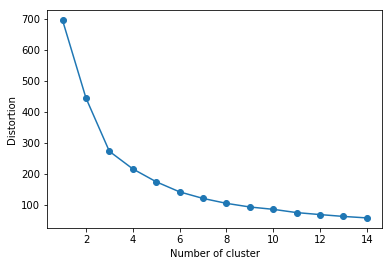

In [59]:
## To find best number of PCA :
# /!\ you have to run again cell before to create real cluster
distortions = []
for i in range (1, 15):
    km = k_means = KMeans(init='k-means++', n_clusters=i, n_init=10).fit(X_scale)
    distortions.append(km.inertia_)
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Number of cluster')
plt.ylabel('Distortion')
plt.show()

In [54]:
station_lyon['station_cluster_geo'] = k_means.labels_

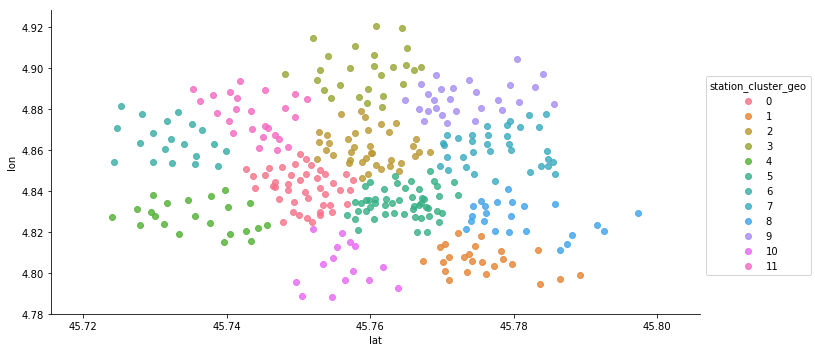

In [55]:
sns.lmplot(x="lat", y="lon", data=station_lyon, hue='station_cluster_geo', scatter=True, fit_reg=False, aspect=2)

In [66]:
# export 
station_lyon.head()
station_lyon.rename(columns={'idstation':'station'}, inplace=True)
station_lyon = station_lyon[['station', 'station_cluster_geo']]
station_lyon.to_csv('data/station_cluster_geo_armand.csv', index=False)

## météo 

In [90]:
lyon_meteo = pd.read_csv('data/lyon_weather.csv', parse_dates=['date'])

In [91]:
lyon_meteo.rename(columns={'date':'ts'}, inplace=True)

In [92]:
lyon_meteo[55:62]

,ts,weather_id,weather_desc,temp,temp_min,temp_max,pressure,humidity,wind_speed,cloudiness
55,2017-08-01 09:20:00,800,Clear,24.47,21.0,26.0,1013.0,54,1.0,0
56,2017-08-01 09:30:00,800,Clear,24.47,21.0,26.0,1013.0,54,1.0,0
57,2017-08-01 09:40:00,800,Clear,25.46,22.0,27.0,1013.0,51,1.5,0
58,2017-08-01 10:00:00,800,Clear,25.46,22.0,27.0,1013.0,51,1.5,0
59,2017-08-01 10:10:00,800,Clear,26.71,22.0,29.0,1013.0,48,1.5,0
60,2017-08-01 10:20:00,800,Clear,26.70,22.0,29.0,1013.0,48,1.5,0
61,2017-08-01 10:30:00,800,Clear,26.70,22.0,29.0,1013.0,48,1.5,0


In [67]:
lyon_meteo.pressure.describe()

count    8714.000000
mean     1017.444658
std         4.307897
min       986.100000
25%      1015.000000
50%      1018.000000
75%      1020.000000
max      1025.000000
Name: pressure, dtype: float64

In [70]:
lyon_meteo[lyon_meteo.pressure >= 1020.000000].tail(10)

,ts,weather_id,weather_desc,temp,temp_min,temp_max,pressure,humidity,wind_speed,cloudiness
8704,2017-09-30 22:20:00,800,Clear,12.49,12.0,13.0,1022.0,87,2.1,0
8705,2017-09-30 22:30:00,800,Clear,12.48,12.0,13.0,1022.0,87,2.1,0
8706,2017-09-30 22:40:00,800,Clear,12.23,11.0,13.0,1022.0,87,1.0,0
8707,2017-09-30 22:50:00,800,Clear,12.23,11.0,13.0,1022.0,87,1.0,0
8708,2017-09-30 23:00:00,800,Clear,12.23,11.0,13.0,1022.0,87,1.0,0
8709,2017-09-30 23:10:00,800,Clear,12.23,11.0,13.0,1022.0,87,1.0,0
8710,2017-09-30 23:20:00,800,Clear,11.99,11.0,13.0,1022.0,93,1.0,0
8711,2017-09-30 23:30:00,800,Clear,11.99,11.0,13.0,1022.0,93,1.0,0
8712,2017-09-30 23:40:00,800,Clear,11.99,11.0,13.0,1022.0,93,1.0,0
8713,2017-09-30 23:50:00,803,Clouds,11.99,11.0,13.0,1022.0,93,1.5,75


In [58]:
lyon_meteo.weather_desc.unique()

array(['Clear', 'Thunderstorm', 'Clouds', 'Rain', 'Mist', 'Fog', 'Drizzle'], dtype=object)

In [60]:
LE = LabelEncoder()

In [61]:
lyon_meteo['weather_desc'] = LE.fit_transform(lyon_meteo['weather_desc'])

In [100]:
joblib.dump(LE, 'model/Label_Encoder_Weather.pkl') 

['model/Label_Encoder_Weather.pkl']

In [101]:
clf = joblib.load('model/Label_Encoder_Weather.pkl') 

In [104]:
clf.transform(['Cleare'])

ValueError: y contains new labels: ['Cleare']

In [62]:
lyon_meteo.tail()

,ts,weather_id,weather_desc,temp,temp_min,temp_max,pressure,humidity,wind_speed,cloudiness
8709,2017-09-30 23:10:00,800,0,12.23,11.0,13.0,1022.0,87,1.0,0
8710,2017-09-30 23:20:00,800,0,11.99,11.0,13.0,1022.0,93,1.0,0
8711,2017-09-30 23:30:00,800,0,11.99,11.0,13.0,1022.0,93,1.0,0
8712,2017-09-30 23:40:00,800,0,11.99,11.0,13.0,1022.0,93,1.0,0
8713,2017-09-30 23:50:00,803,1,11.99,11.0,13.0,1022.0,93,1.5,75


#### resample meteo

In [75]:
clean_lyon_meteo = lyon_meteo.resample("10T", on="ts").mean().bfill().reset_index()

In [76]:
clean_lyon_meteo[55:62]

,ts,weather_id,weather_desc,temp,temp_min,temp_max,pressure,humidity,wind_speed,cloudiness
55,2017-08-01 09:20:00,800.0,0.0,24.47,21.0,26.0,1013.0,54.0,1.0,0.0
56,2017-08-01 09:30:00,800.0,0.0,24.47,21.0,26.0,1013.0,54.0,1.0,0.0
57,2017-08-01 09:40:00,800.0,0.0,25.46,22.0,27.0,1013.0,51.0,1.5,0.0
58,2017-08-01 09:50:00,800.0,0.0,25.46,22.0,27.0,1013.0,51.0,1.5,0.0
59,2017-08-01 10:00:00,800.0,0.0,25.46,22.0,27.0,1013.0,51.0,1.5,0.0
60,2017-08-01 10:10:00,800.0,0.0,26.71,22.0,29.0,1013.0,48.0,1.5,0.0
61,2017-08-01 10:20:00,800.0,0.0,26.70,22.0,29.0,1013.0,48.0,1.5,0.0


#### Merging train_X

In [65]:
train_X.reset_index(inplace=True)

In [77]:
train_X.head()

,ts,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,...,station_cluster_geo,bikes_shift_1Hmin,cumsum_trend_sup,cumsum_trend_inf,cumsum_trend_equal,was_recently_open,total_stand,filling_station_by_geo_cluster,paa,sax
0,2017-08-01 00:10:00,1001,10.0,6.0,1.0,1,0,0,1,0,...,5,10.0,0,0,0,1.0,16.0,0.456444,0.625000,0.623393
1,2017-08-01 00:10:00,1002,17.0,5.0,1.0,1,0,0,1,0,...,5,17.0,0,0,1,24.0,22.0,0.456444,0.570455,0.595576
2,2017-08-01 00:10:00,1003,14.0,1.0,1.0,1,0,0,1,0,...,5,14.0,0,0,1,24.0,15.0,0.456444,0.740000,0.767377
3,2017-08-01 00:10:00,1005,1.0,9.0,1.0,1,0,0,1,0,...,5,1.0,0,0,1,24.0,10.0,0.456444,0.125000,0.150893
4,2017-08-01 00:10:00,1006,11.0,11.0,1.0,1,0,0,1,0,...,5,11.0,0,0,3,24.0,22.0,0.456444,0.402273,0.430791


In [78]:
train_X.shape

(2554704, 22)

In [79]:
lol = train_X.merge(clean_lyon_meteo[['ts', 'temp', 'humidity', 'weather_desc']], on='ts', how='left')

In [80]:
pd.isnull(lol[['temp', 'humidity']]).sum()

temp        0
humidity    0
dtype: int64

In [81]:
lol.shape

(2554704, 25)

In [82]:
lol.head()

,ts,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,...,cumsum_trend_inf,cumsum_trend_equal,was_recently_open,total_stand,filling_station_by_geo_cluster,paa,sax,temp,humidity,weather_desc
0,2017-08-01 00:10:00,1001,10.0,6.0,1.0,1,0,0,1,0,...,0,0,1.0,16.0,0.456444,0.625000,0.623393,26.7,39.0,0.0
1,2017-08-01 00:10:00,1002,17.0,5.0,1.0,1,0,0,1,0,...,0,1,24.0,22.0,0.456444,0.570455,0.595576,26.7,39.0,0.0
2,2017-08-01 00:10:00,1003,14.0,1.0,1.0,1,0,0,1,0,...,0,1,24.0,15.0,0.456444,0.740000,0.767377,26.7,39.0,0.0
3,2017-08-01 00:10:00,1005,1.0,9.0,1.0,1,0,0,1,0,...,0,1,24.0,10.0,0.456444,0.125000,0.150893,26.7,39.0,0.0
4,2017-08-01 00:10:00,1006,11.0,11.0,1.0,1,0,0,1,0,...,0,3,24.0,22.0,0.456444,0.402273,0.430791,26.7,39.0,0.0


In [435]:
print(lyon_meteo.date.min())
print(lyon_meteo.date.max())

2017-08-01 00:10:00
2017-09-30 23:50:00


In [44]:
lyon_meteo = pd.read_csv('data/lyon_weather.csv', parse_dates=['date'])
lyon_meteo.rename(columns={'date':'ts'}, inplace=True)

# have to labelencode weather_desc
LE = LabelEncoder()
lyon_meteo['weather_desc'] = LE.fit_transform(lyon_meteo['weather_desc'])

# Dump LabelEncoder
joblib.dump(LE, 'model/Label_Encoder_Weather.pkl')

# Resemple data on 10
clean_lyon_meteo = lyon_meteo.resample("10T", on="ts").mean().bfill().reset_index()

In [45]:
clean_lyon_meteo.head()

,ts,weather_id,weather_desc,temp,temp_min,temp_max,pressure,humidity,wind_speed,cloudiness
0,2017-08-01 00:10:00,800.0,0.0,26.70,24.0,28.0,1011.0,39.0,3.1,0.0
1,2017-08-01 00:20:00,800.0,0.0,26.22,24.0,27.0,1011.0,39.0,1.0,0.0
2,2017-08-01 00:30:00,800.0,0.0,26.22,24.0,27.0,1011.0,39.0,1.0,0.0
3,2017-08-01 00:40:00,800.0,0.0,26.22,24.0,27.0,1011.0,39.0,1.0,0.0
4,2017-08-01 00:50:00,800.0,0.0,24.72,21.0,27.0,1011.0,44.0,1.5,0.0


In [46]:
X_train.head()

,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,public_holiday_count,...,station_cluster_geo,bikes_shift_1Hmin,cumsum_trend_sup,cumsum_trend_inf,cumsum_trend_equal,was_recently_open,total_stand,filling_station_by_geo_cluster,paa,sax
ts,,,,,,,,,,,,,,,,,,,,,
2017-09-13 21:20:00,3067,14.0,1.0,1.0,2,21,10,0,0,0.0,...,2,13.5,2,0,0,24.0,15.0,0.422381,0.910000,0.884635
2017-08-29 16:40:00,7012,12.0,1.0,1.0,1,16,30,1,0,0.0,...,4,12.0,0,0,19,24.0,13.0,0.657379,0.923077,0.925245
2017-09-16 04:10:00,7010,6.0,14.0,1.0,5,4,0,0,0,0.0,...,0,5.0,1,0,0,24.0,20.0,0.660374,0.245000,0.266291
2017-08-28 15:30:00,8003,2.0,14.0,1.0,0,15,20,1,0,0.0,...,11,2.0,0,0,13,24.0,16.0,0.498904,0.125000,0.123527
2017-08-25 23:30:00,4006,1.0,21.0,1.0,4,23,20,1,0,0.0,...,8,1.0,0,0,21,24.0,22.0,0.349383,0.045455,0.046222


In [214]:
def get_weather(df, how='learning', freq=None):
    """
    Match timeseries with weather data.
    If type == learning :
        Matching with historitical data weather
    if type == forcast :
        Matching with forcast data. Freq must be fill with this opton
    """

    df = df.reset_index()

    # Check params
    if how not in ['learning', 'forecast']:
        logger.error('Bad option for get_weather. You must choose between learning or forecast')
        return df

    if how == 'forecast' and freq is None:
        logger.error("For forecast option, we must specify freq. Ex freq='1H'")


    # Process for learning matching
    if how == 'learning':
        lyon_meteo = pd.read_csv('data/lyon_weather.csv', parse_dates=['date'])
        lyon_meteo.rename(columns={'date':'ts'}, inplace=True)

        # have to labelencode weather_desc
        LE = LabelEncoder()
        lyon_meteo['weather_desc'] = LE.fit_transform(lyon_meteo['weather_desc'])

        # Dump LabelEncoder
        joblib.dump(LE, 'model/Label_Encoder_Weather.pkl')

        # Resemple data on 10
        clean_lyon_meteo = lyon_meteo.resample("10T", on="ts").mean().bfill().reset_index()
        df = df.merge(clean_lyon_meteo[['ts', 'temp', 'humidity', 'weather_desc']], on='ts', how='left')
        
        df = df.set_index('ts')
        return df

    # Process for forecast matching
    if how == 'forecast':
        lyon_forecast = pd.read_csv('data/lyon_forecast.csv', parse_dates=['forecast_at', 'ts'])
        lyon_forecast['delta'] = lyon_forecast['ts'] - lyon_forecast['forecast_at']

        # Filter on delta with freq
        lyon_forecast = lyon_forecast[lyon_forecast['delta'] == freq]
        lyon_forecast.drop_duplicates(subset=['ts', 'delta'], keep='first', inplace=True)
        
        # Label encode weather_desc
        LE = joblib.load('model/Label_Encoder_Weather.pkl') 
        lyon_forecast['weather_desc'] = LE.transform(lyon_forecast['weather_desc'])

        #Merging
        # We talk the last forecast (on freq) using backward merging
        df = df.sort_values('ts')
        df = pd.merge_asof(left=df, right=lyon_forecast[['ts','temp', 'humidity', 'weather_desc']], on='ts', direction='backward')

        df = df.set_index('ts')
        return df

In [53]:
del lol

### Forecast

In [88]:
lyon_forecast = pd.read_csv('data/lyon_forecast.csv', parse_dates=['forecast_at', 'ts'])

In [89]:
lyon_forecast.head()

,forecast_at,ts,weather_id,weather_desc,temp,temp_min,temp_max,rain_3h,snow_3h,pressure,humidity,wind_speed,cloudiness
0,2017-08-01,2017-08-01 02:00:00,800,Clear,26.06,26.06,26.16,NaN,NaN,982.16,36,6.51,8
1,2017-08-01,2017-08-01 05:00:00,800,Clear,25.64,25.64,25.72,NaN,NaN,981.74,36,7.09,8
2,2017-08-01,2017-08-01 08:00:00,500,Rain,25.83,25.83,25.88,0.025,NaN,982.54,44,6.83,20
3,2017-08-01,2017-08-01 11:00:00,500,Rain,29.75,29.75,29.77,0.160,NaN,983.02,44,6.05,0
4,2017-08-01,2017-08-01 14:00:00,803,Clouds,32.56,32.56,32.56,NaN,NaN,982.83,35,7.16,76


In [90]:
lyon_forecast.weather_desc.unique()

array(['Clear', 'Rain', 'Clouds'], dtype=object)

In [91]:
lyon_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86102 entries, 0 to 86101
Data columns (total 13 columns):
forecast_at     86102 non-null datetime64[ns]
ts              86102 non-null datetime64[ns]
weather_id      86102 non-null int64
weather_desc    86102 non-null object
temp            86102 non-null float64
temp_min        86102 non-null float64
temp_max        86102 non-null float64
rain_3h         25824 non-null float64
snow_3h         0 non-null float64
pressure        86102 non-null float64
humidity        86102 non-null int64
wind_speed      86102 non-null float64
cloudiness      86102 non-null int64
dtypes: datetime64[ns](2), float64(7), int64(3), object(1)
memory usage: 8.5+ MB


In [92]:
lyon_forecast['delta'] = lyon_forecast['ts'] - lyon_forecast['forecast_at']

In [93]:
lyon_forecast = lyon_forecast[lyon_forecast['delta'] == "1H"]
lyon_forecast.drop_duplicates(subset=['ts', 'delta'], keep='first', inplace=True)

In [126]:
LE = joblib.load('model/Label_Encoder_Weather.pkl') 
lyon_forecast['weather_desc'] = LE.transform(lyon_forecast['weather_desc'])

In [229]:
lyon_forecast[(lyon_forecast.ts >= "2017-08-01 07:00:00") & (lyon_forecast.delta == "1H")].head()

,forecast_at,ts,weather_id,weather_desc,temp,temp_min,temp_max,rain_3h,snow_3h,pressure,humidity,wind_speed,cloudiness,delta
273,2017-08-01 07:00:00,2017-08-01 08:00:00,500,5,20.82,20.82,25.88,0.025,NaN,982.54,44,6.83,20,01:00:00
385,2017-08-01 10:00:00,2017-08-01 11:00:00,500,5,29.44,29.44,29.77,0.160,NaN,983.02,44,6.05,0,01:00:00
494,2017-08-01 13:00:00,2017-08-01 14:00:00,803,1,31.95,31.95,32.56,NaN,NaN,982.83,35,7.16,76,01:00:00
600,2017-08-01 16:00:00,2017-08-01 17:00:00,802,1,30.55,30.07,30.55,NaN,NaN,983.80,48,5.96,48,01:00:00
720,2017-08-01 19:00:00,2017-08-01 20:00:00,804,1,27.31,27.31,27.99,NaN,NaN,985.40,55,2.58,88,01:00:00


In [153]:
#lyon_forecast[(lyon_forecast.ts >= "2017-08-01 00:10:00") & (lyon_forecast.delta == "1H")]

In [215]:
X_test.head(2)

,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,public_holiday_count,...,station_cluster_geo,bikes_shift_1Hmin,cumsum_trend_sup,cumsum_trend_inf,cumsum_trend_equal,was_recently_open,total_stand,filling_station_by_geo_cluster,paa,sax
ts,,,,,,,,,,,,,,,,,,,,,
2017-08-23 18:00:00,9010,10.0,9.0,1.0,2,18,0,1,0,0.0,...,1,10.0,0,0,6,24.0,19.0,0.596376,0.552632,0.550343
2017-09-16 14:30:00,1022,30.0,1.0,1.0,5,14,20,0,0,0.0,...,5,30.0,0,0,1,24.0,31.0,0.758573,0.686022,0.711584


In [216]:
lol = get_weather(X_test, how='forecast', freq='1H')

In [235]:
lol[lol.index.isin(['2017-08-01 10:00:00','2017-08-01 11:00:00'])].tail()

,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,public_holiday_count,...,cumsum_trend_inf,cumsum_trend_equal,was_recently_open,total_stand,filling_station_by_geo_cluster,paa,sax,temp,humidity,weather_desc
ts,,,,,,,,,,,,,,,,,,,,,
2017-08-01 11:00:00,3088,14.0,2.0,1.0,1,11,0,1,0,0.0,...,0,1,24.0,16.0,0.664074,0.834375,0.836449,29.44,44,5
2017-08-01 11:00:00,6001,14.0,1.0,1.0,1,11,0,1,0,0.0,...,0,2,24.0,15.0,0.664074,0.926667,0.922586,29.44,44,5
2017-08-01 11:00:00,3029,4.0,19.0,1.0,1,11,0,1,0,0.0,...,1,0,24.0,23.0,0.421277,0.160870,0.163770,29.44,44,5
2017-08-01 11:00:00,4023,14.0,7.0,1.0,1,11,0,1,0,0.0,...,0,3,24.0,21.0,0.640138,0.650000,0.652840,29.44,44,5
2017-08-01 11:00:00,3051,11.0,2.0,1.0,1,11,0,1,0,0.0,...,0,6,24.0,13.0,0.537528,0.730769,0.731793,29.44,44,5


In [232]:
lol.head()

,station,bikes,stands,is_open,day,hour,minute,is_holiday,public_holiday,public_holiday_count,...,cumsum_trend_inf,cumsum_trend_equal,was_recently_open,total_stand,filling_station_by_geo_cluster,paa,sax,temp,humidity,weather_desc
ts,,,,,,,,,,,,,,,,,,,,,
2017-08-01 02:00:00,10088,18.0,1.0,1.0,1,2,0,1,0,0.0,...,0,2,24.0,19.0,0.460417,0.947368,0.948087,24.47,36,0
2017-08-01 02:00:00,10102,6.0,24.0,1.0,1,2,0,1,0,0.0,...,0,1,24.0,30.0,0.375505,0.200000,0.199909,24.47,36,0
2017-08-01 02:00:00,2014,1.0,15.0,1.0,1,2,0,1,0,0.0,...,0,2,24.0,16.0,0.363962,0.062500,0.063656,24.47,36,0
2017-08-01 02:00:00,4003,1.0,16.0,1.0,1,2,0,1,0,0.0,...,0,92,24.0,17.0,0.336585,0.058824,0.059792,24.47,36,0
2017-08-01 02:00:00,8008,4.0,9.0,1.0,1,2,0,1,0,0.0,...,0,1,24.0,13.0,0.853293,0.319231,0.292275,24.47,36,0


In [222]:
lyon_forecast[(lyon_forecast.ts >= "2017-08-01 07:00:00")].head(5)

,forecast_at,ts,weather_id,weather_desc,temp,temp_min,temp_max,rain_3h,snow_3h,pressure,humidity,wind_speed,cloudiness,delta
273,2017-08-01 07:00:00,2017-08-01 08:00:00,500,5,20.82,20.82,25.88,0.025,NaN,982.54,44,6.83,20,01:00:00
385,2017-08-01 10:00:00,2017-08-01 11:00:00,500,5,29.44,29.44,29.77,0.160,NaN,983.02,44,6.05,0,01:00:00
494,2017-08-01 13:00:00,2017-08-01 14:00:00,803,1,31.95,31.95,32.56,NaN,NaN,982.83,35,7.16,76,01:00:00
600,2017-08-01 16:00:00,2017-08-01 17:00:00,802,1,30.55,30.07,30.55,NaN,NaN,983.80,48,5.96,48,01:00:00
720,2017-08-01 19:00:00,2017-08-01 20:00:00,804,1,27.31,27.31,27.99,NaN,NaN,985.40,55,2.58,88,01:00:00


In [166]:
#X_test = X_test.reset_index()
#Merging
# We talk the last forecast (on freq) using backward merging
#X_test = X_test.sort_values('ts')
lol = pd.merge_asof(left=X_test, right=lyon_forecast[['ts','temp', 'humidity', 'weather_desc']], on='ts', direction='backward')

In [176]:
print(lyon_forecast.ts.min())
print(lyon_forecast.ts.max())

2017-08-01 02:00:00
2017-09-30 23:00:00


## Some maps

CSV file with station coordinates

In [48]:
locations = pd.read_csv("./data/lyon-stations.csv")

In [49]:
locations.shape

(348, 4)

Some stations were removed when the data were cleaned up. Remove them from the location data.

In [50]:
mask = locations['idstation'].isin(result.station.unique())

In [51]:
mask.sum()

337

In [52]:
locations = locations[mask]

In [53]:
locations = locations.rename_axis({'idstation': 'station'}, axis=1)

In [54]:
locations.head()

,station,nom,lat,lon
0,10027,Mairie de Villeurbanne,45.766831,4.879894
1,10030,Greuze,45.773844,4.893848
2,10034,MJC,45.761788,4.886157
3,10036,Chaplin / Dutriévoz,45.774357,4.859155
4,10038,Condorcet / 11 Nov. 1918,45.779046,4.866778


Some station names contains the `'` character. Replace it by the HTML code for folium.

In [78]:
locations["nom"] = locations['nom'].str.replace("'", "&apos;")

Select the prediction data for a specific timestamp

In [79]:
data_to_plot = result.loc[predict_date]

In [80]:
data_to_plot.shape

(337, 12)

In [81]:
data_to_plot.head()

,station,bikes,stands,day,hour,minute,ts_future,observation,prediction,error,relative_error,quad_error
ts,,,,,,,,,,,,
2017-07-26 10:00:00,1001,2.0,14.0,2,10,0,2017-07-26 10:30:00,0.375000,0.140736,-0.234264,62.470392,0.054880
2017-07-26 10:00:00,1002,8.0,14.0,2,10,0,2017-07-26 10:30:00,0.255814,0.358517,0.102703,40.147679,0.010548
2017-07-26 10:00:00,1003,2.0,13.0,2,10,0,2017-07-26 10:30:00,0.133333,0.145994,0.012661,9.495718,0.000160
2017-07-26 10:00:00,1005,2.0,8.0,2,10,0,2017-07-26 10:30:00,0.300000,0.227014,-0.072986,24.328576,0.005327
2017-07-26 10:00:00,1006,2.0,19.0,2,10,0,2017-07-26 10:30:00,0.047619,0.109391,0.061772,129.721656,0.003816


In [83]:
yhat = data_to_plot[['station', 'prediction']].merge(locations, on='station')
yhat.head()

,station,prediction,nom,lat,lon
0,1001,0.140736,Terreaux / Terme,45.767735,4.832135
1,1002,0.358517,Opéra,45.767507,4.836282
2,1003,0.145994,Place Sathonay,45.769266,4.830080
3,1005,0.227014,Meissonier,45.766089,4.832890
4,1006,0.109391,Subsistances,45.767896,4.819817


In [104]:
y = data_to_plot[['station', 'observation']].merge(locations, on='station')

In [140]:
error = data_to_plot[['station', 'error']].merge(locations, on='station')

In [122]:
colormap = 'RdYlBu'
cmap = plt.get_cmap(colormap)

See 

* https://matplotlib.org/examples/color/colormaps_reference.html
* https://matplotlib.org/api/colors_api.html

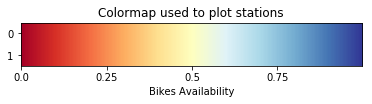

In [137]:
# show the colormap use to plot the stations, values [0, 1]
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig, ax = plt.subplots(1)
fig.subplots_adjust(top=0.95, bottom=0.80, left=0.2, right=0.99)
ax.set_xticks([0., 64, 128, 192, 256])
ax.set_xticklabels([0., 0.25, 0.5, 0.75, 1.])
ax.set_xlabel('Bikes Availability')
ax.imshow(gradient, aspect='auto', cmap=cmap, vmin=0, vmax=1)
plt.title('Colormap used to plot stations')

* Red stations if there are 0 or a few available bikes
* Blue stations if there are several available bikes

In [95]:
color = lambda x: mpl.colors.to_hex(cmap(x))

In [89]:
# Lyon (France) Position
position = [45.750000, 4.850000]

In [106]:
mp_pred = folium.Map(location=position, zoom_start=13, tiles='cartodbpositron')

In [107]:
# Map of the predicted values
for _,row in yhat.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,
        popup=row['nom'],
        color=color(row['prediction']),
        fill=True,
        fill_opacity=0.3,
        fill_color=color(row['prediction'])
    ).add_to(mp_pred)

In [102]:
mp_pred

In [108]:
# Map for the observation
mp_obs = folium.Map(location=position, zoom_start=13, tiles='cartodbpositron')

In [109]:
# Map of the observations
for _,row in y.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,
        popup=row['nom'],
        color=color(row['observation']),
        fill=True,
        fill_opacity=0.3,
        fill_color=color(row['observation'])
    ).add_to(mp_obs)

In [138]:
mp_obs

In [153]:
# Colormap for error (by default, the color map fits for [0, 1] values)
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
color_error = lambda x: mpl.colors.to_hex(cmap(norm(x)))

In [154]:
# Map for the errors
mp_error = folium.Map(location=position, zoom_start=13, tiles='cartodbpositron')

In [155]:
# Map of the errors
for _,row in error.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,
        popup=row['nom'],
        color=color_error(row['error']),
        fill=True,
        fill_opacity=0.3,
        fill_color=color_error(row['error'])
    ).add_to(mp_error)

In [156]:
mp_error